# Moore’s Law Linear Regression

You are given a dataset describing Moore’s Law, stored in the file **`./datat/moore.csv`**.  
Each record contains information about the **year**, **transistor count**, and other details for integrated circuits.  
Your task is to implement a simple **linear regression model** in **PyTorch** to estimate the rate at which transistor counts have historically increased.

---
---

### Expected Output

- Scatter plots of data before and after preprocessing  
- A decreasing loss curve across epochs  
- A final fitted regression line  
- Calculated doubling‑time value (approximately **2 years** for real Moore’s Law data)


#### Your answer:

In [22]:
from google.colab import files
import io, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import math

uploaded = files.upload()
filename = "moore.csv"
print(f"File uploaded: {filename}")



Saving moore.csv to moore.csv
File uploaded: moore.csv


In [28]:
# Read the file as plain text
# Convert the data from binary format to string then turn it into a file-like object, so you can read it line by line.
text = io.StringIO(uploaded[filename].decode("utf-8", errors="ignore"))
lines = text.readlines()

# Save "raw" numbers before cleaning for ploting the data before cleaning
raw_data_before = []
for line in lines:
    nums = re.findall(r"[\d,]+", line) # matches any digit (\d) or comma (,) and return all matches as a list
    year_match = re.search(r"\b(19\d{2}|20\d{2})\b", line)
    #\b: word boundary (start/end of a number or word)
    #19\d{2}: any number starting with 19 + 2 digits (e.g., 1971, 1985)
    #20\d{2}: any number starting with 20 + 2 digits (e.g., 2003, 2015)
    #re.search(): finds the first match in the string
    if nums and year_match:
        try:
            trans = int(nums[0].replace(",", "")) # Remove commas and convert string to integer
            year = int(year_match.group(1))
            raw_data_before.append((year, trans))
        except:
            pass
raw_df = pd.DataFrame(raw_data_before, columns=["Year", "Transistors"])

# Clean the data
clean_rows = []
for line in lines:
    nums = re.findall(r"[\d,]+", line)
    year_match = re.search(r"\b(19\d{2}|20\d{2})\b", line)
    if year_match and len(nums) >= 2: # Having a matched year and at least 2 numbers.
        try:
            year = int(year_match.group(1))
            nums_int = [int(n.replace(",", "")) for n in nums]
            candidates = [n for n in nums_int if n >= 1000] # Ignore the wierd number for transistor counts.
            if len(candidates) == 0:
                continue
            trans = max(candidates) # Get the largest number in the line.
            clean_rows.append((year, trans))
        except:
            pass

df = pd.DataFrame(clean_rows, columns=["Year", "Transistors"])
print("*Cleaned dataset preview:")
print(df.head(20))


*Cleaned dataset preview:
    Year  Transistors
0   1971        10000
1   1972        10000
2   1974         8080
3   1974         6800
4   1974         5000
5   1974         8000
6   1975         8000
7   1976         8085
8   1976         8500
9   1978        29000
10  1978         9000
11  1979        29000
12  1979        68000
13  1981        11500
14  1982        80186
15  1982       134000
16  1983        22000
17  1984       190000
18  1985        25000
19  1985       275000


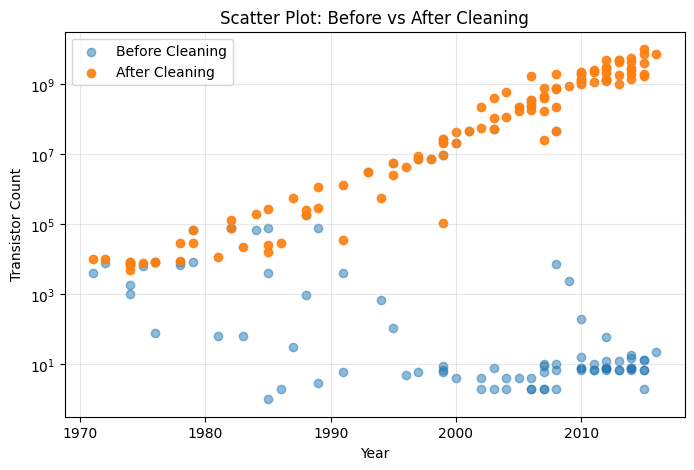

In [29]:
# Visualize Before & After Cleaning

plt.figure(figsize=(8,5))
plt.scatter(raw_df["Year"], raw_df["Transistors"], label="Before Cleaning", alpha=0.5)
plt.scatter(df["Year"], df["Transistors"], label="After Cleaning", alpha=0.9)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Transistor Count")
plt.title("Scatter Plot: Before vs After Cleaning")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [30]:
# Prepare Data for Regression

df["Log10_Trans"] = np.log10(df["Transistors"])
year0 = df["Year"].min()
df["Year_shift"] = df["Year"] - year0

X = torch.tensor(df["Year_shift"].values, dtype=torch.float32).view(-1,1)
y = torch.tensor(df["Log10_Trans"].values, dtype=torch.float32).view(-1,1)

Epoch 500/3000, Loss = 1.105996
Epoch 1000/3000, Loss = 0.824945
Epoch 1500/3000, Loss = 0.646065
Epoch 2000/3000, Loss = 0.519522
Epoch 2500/3000, Loss = 0.430003
Epoch 3000/3000, Loss = 0.366675


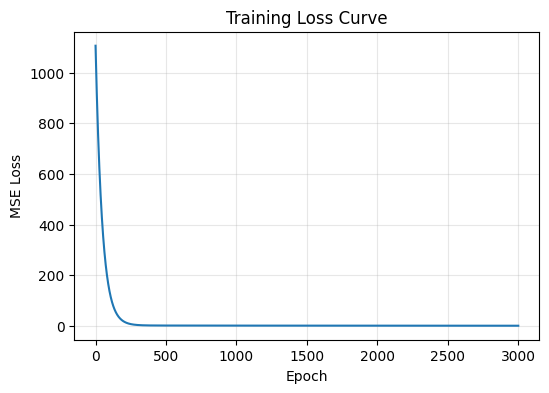

In [31]:
# Build & Train the Model

model = nn.Linear(1,1)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

epochs = 3000
losses = []
for epoch in range(epochs):
    y_pred = model(X)             #Forward pass: predict log10(Transistors)
    loss = loss_fn(y_pred, y)     #Compute MSE loss
    optimizer.zero_grad()         #Clear previous gradients
    loss.backward()               #Backpropagation: compute gradients
    optimizer.step()              #Update weights w and b
    losses.append(loss.item())    #Save loss for plotting
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.6f}")

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(alpha=0.3)
plt.show()


In [32]:
# Results & Fitted Line

w = model.weight.item()
b = model.bias.item()

print(f"\nModel: log10(Transistors) = {w:.6f}*(Year - {year0}) + {b:.6f}")

doubling_time = math.log10(2) / w
print(f"📈 Doubling time ≈ {doubling_time:.2f} years")

y_fit = model(X).detach().numpy() # Converts PyTorch tensor to normal NumPy array for plotting/evaluation without gradients
r2 = r2_score(y, y_fit)
print(f"R² = {r2:.4f}")



Model: log10(Transistors) = 0.176323*(Year - 1971) + 2.174081
📈 Doubling time ≈ 1.71 years
R² = 0.9094


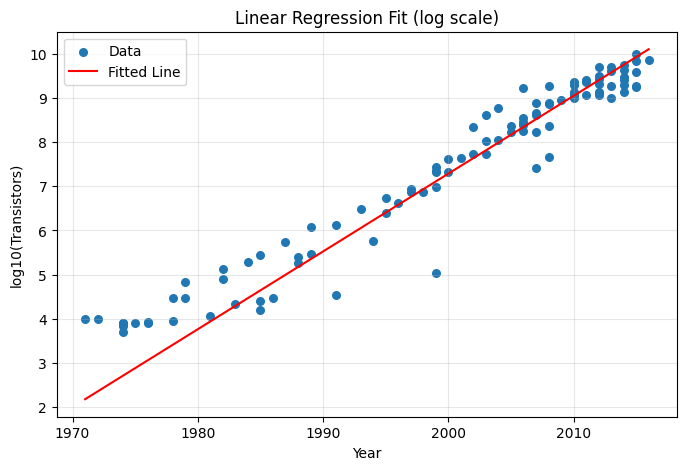

In [33]:
# Plot Fitted Regression Line

plt.figure(figsize=(8,5))
plt.scatter(df["Year"], df["Log10_Trans"], label="Data", s=30)
plt.plot(df["Year"], y_fit, color='r', label="Fitted Line")
plt.xlabel("Year")
plt.ylabel("log10(Transistors)")
plt.title("Linear Regression Fit (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


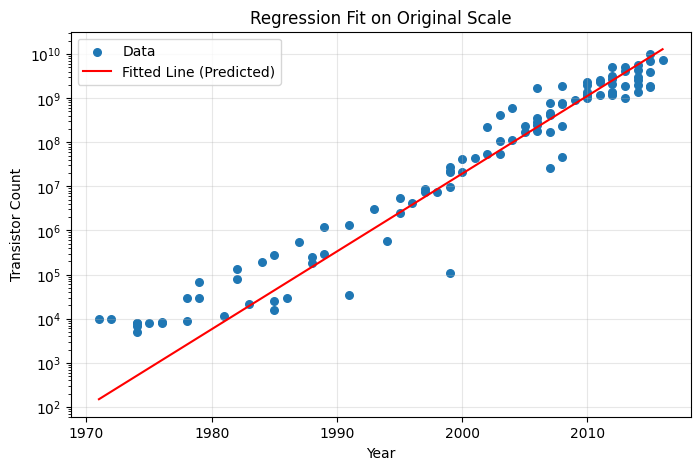

In [34]:
# Plot on Original Scale

plt.figure(figsize=(8,5))
plt.scatter(df["Year"], df["Transistors"], label="Data", s=30)
plt.plot(df["Year"], 10**y_fit, color='r', label="Fitted Line (Predicted)")
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Transistor Count")
plt.title("Regression Fit on Original Scale")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
